In [1]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Tabs, TabPanel, Legend,  Toggle, LegendItem, CustomJS, Select, Button
from bokeh.palettes import Category20
from bokeh.layouts import column
import os

# LinkedIn Industry Performance Analysis: Bangladesh 2017-2024

This notebook analyses LinkedIn Hiring Rate, Skills and Skills Penetration by Gender in Bangladesh. 

## LinkedIn Hiring Rate

In [2]:
COUNTRY = 'Bangladesh'
os.environ['COUNTRY'] = COUNTRY

In [3]:
def clean_linkedin_data(excel_file):
    """Clean and prepare LinkedIn data from Excel file."""
    try:
        # Load the specific sheet with correct header row
        data_corrected = pd.read_excel(excel_file, sheet_name="2B - LHR by Ctry, Ind", header=3)
        
        # Rename columns and clean data
        data_cleaned = data_corrected.rename(columns={
            'Unnamed: 1': 'Month',
            'Unnamed: 2': 'Country',
            'Unnamed: 3': 'Industry',
            'Unnamed: 4': 'LHR (YOY)'
        })
        
        # Remove rows with missing data
        data_cleaned = data_cleaned.dropna(subset=['Month', 'Country', 'Industry', 'LHR (YOY)'])
        
        # Remove the first row (duplicate headers)
        data_cleaned = data_cleaned.iloc[1:]
        
        # Remove the column containing only NaN values
        data_cleaned = data_cleaned.drop(columns=['Unnamed: 0'])
        
        return data_cleaned
        
    except Exception as e:
        print(f"Error during data cleaning: {str(e)}")
        return None

In [4]:
def create_industry_performance_plots(excel_file):
    """Create interactive plots showing industry performance in Bangladesh, with toggle to filter from 2022."""
    output_notebook()

    try:
        # Clean the data
        df = clean_linkedin_data(excel_file)
        if df is None:
            print("Data cleaning failed. Please check your Excel file.")
            return

        # Filter data for Bangladesh
        country = os.getenv('COUNTRY')
        bd_data = df[df['Country'] == country].copy()

        # Convert Month to datetime
        bd_data['Month'] = pd.to_datetime(bd_data['Month'])

        # Calculate average LHR for each industry
        industry_avg = bd_data.groupby('Industry')['LHR (YOY)'].mean().sort_values(ascending=False)

        # Split industries into quartiles (5 industries each)
        top_5 = industry_avg.head(5).index.tolist()
        upper_mid_5 = industry_avg.iloc[5:10].index.tolist()
        lower_mid_5 = industry_avg.iloc[10:15].index.tolist()
        bottom_5 = industry_avg.iloc[15:].index.tolist()

        # Define quartile categories
        categories = [
            ('Leading Industries', top_5, 'Top Performing Industries (1st Quartile)'),
            ('Growing Industries', upper_mid_5, 'Strong Performing Industries (2nd Quartile)'),
            ('Transitioning Industries', lower_mid_5, 'Moderate Performing Industries (3rd Quartile)'),
            ('Emerging Industries', bottom_5, 'Developing Industries (4th Quartile)')
        ]

        tabs = []

        # Create one tab per industry category
        for tab_title, industries, plot_title in categories:
            # Prepare full and filtered data
            plot_data_full = bd_data[bd_data['Industry'].isin(industries)].copy()
            plot_data_filtered = plot_data_full[plot_data_full['Month'] >= '2022-01-01'].copy()

            # Create figure
            p = figure(
                title=f"LinkedIn Hiring Rate: {plot_title} in Bangladesh",
                x_axis_type='datetime',
                width=800,
                height=500,
                background_fill_color="#f8f9fa"
            )

            legend_items = []
            js_sources = []

            for i, industry in enumerate(industries):
                color = Category20[10][i]

                full_industry_data = plot_data_full[plot_data_full['Industry'] == industry]
                filtered_industry_data = plot_data_filtered[plot_data_filtered['Industry'] == industry]

                source = ColumnDataSource(full_industry_data)
                source_full = ColumnDataSource(full_industry_data)
                source_filtered = ColumnDataSource(filtered_industry_data)

                line = p.line(
                    x='Month',
                    y='LHR (YOY)',
                    source=source,
                    line_width=3,
                    color=color
                )

                legend_items.append((f"{industry} (Avg: {industry_avg[industry]:.2f}%)", [line]))
                js_sources.append({'source': source, 'full': source_full, 'filtered': source_filtered})

            # Add hover
            p.add_tools(HoverTool(
                tooltips=[
                    ("Month", "@Month{%b %Y}"),
                    ("LHR (YOY)", "@{LHR (YOY)}{0.00}%"),
                    ("Industry", "@Industry")
                ],
                formatters={"@Month": "datetime"},
                mode='vline'
            ))

            # Axes labels and styling
            p.xaxis.axis_label = 'Month'
            p.yaxis.axis_label = 'LinkedIn Hiring Rate (YOY %)'
            p.xaxis.axis_label_text_font_size = '12pt'
            p.yaxis.axis_label_text_font_size = '12pt'
            p.xaxis.major_label_text_font_size = '10pt'
            p.yaxis.major_label_text_font_size = '10pt'
            p.title.text_font_size = '14pt'
            p.grid.grid_line_color = "gray"
            p.grid.grid_line_alpha = 0.3

            # Add legend
            legend = Legend(
                items=legend_items,
                orientation='horizontal',
                spacing=20,
                padding=10,
                click_policy="hide",
                label_text_font_size='9pt',
                border_line_color="gray",
                border_line_alpha=0.5,
                background_fill_alpha=0.7,
                nrows=3
            )
            p.add_layout(legend, 'below')

            # Toggle button
            toggle = Toggle(label="Filter from 2022", button_type="success", active=False)

            # JS callback
            callback_code = """
                for (let i = 0; i < sources.length; i++) {
                    sources[i].data = toggle.active ? filtered[i].data : full[i].data;
                    sources[i].change.emit();
                }
                toggle.label = toggle.active ? 'Show full range' : 'Filter from 2022';
                toggle.button_type = toggle.active ? 'warning' : 'success';
        """

            callback = CustomJS(args={
                "toggle": toggle,
                "sources": [src['source'] for src in js_sources],
                "full": [src['full'] for src in js_sources],
                "filtered": [src['filtered'] for src in js_sources]
                }, code=callback_code)

            toggle.js_on_change("active", callback)

            # Combine toggle and plot
            tab_layout = column(toggle, p)
            tab = TabPanel(child=tab_layout, title=tab_title)
            tabs.append(tab)

        # Show tabs
        if tabs:
            tabs_layout = Tabs(tabs=tabs)
            show(tabs_layout)
        else:
            print("No data available for visualization.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your Excel file structure and column names.")



In [5]:
def export_industry_metrics(excel_file, output_path='industry_performance_metrics.csv'):
    """Export industry performance metrics to CSV file."""
    try:
        # Clean the data
        df = clean_linkedin_data(excel_file)
        
        if df is None:
            return None
            
        # Filter data for Bangladesh
        bd_data = df[df['Country'] == 'Bangladesh'].copy()
        bd_data['Month'] = pd.to_datetime(bd_data['Month'])
        
        # Calculate metrics for each industry
        metrics_list = []
        for industry in bd_data['Industry'].unique():
            industry_data = bd_data[bd_data['Industry'] == industry]
            
            # Calculate various metrics
            metrics = {
                'Industry': industry,
                'Average_LHR': industry_data['LHR (YOY)'].mean(),
                'Max_LHR': industry_data['LHR (YOY)'].max(),
                'Min_LHR': industry_data['LHR (YOY)'].min(),
                'Volatility': industry_data['LHR (YOY)'].std(),
                'Latest_LHR': industry_data.loc[industry_data['Month'].idxmax(), 'LHR (YOY)'],
                'Growth_Trend': industry_data['LHR (YOY)'].iloc[-1] - industry_data['LHR (YOY)'].iloc[0],
                'Start_Date': industry_data['Month'].min().strftime('%Y-%m'),
                'End_Date': industry_data['Month'].max().strftime('%Y-%m')
            }
            metrics_list.append(metrics)
        
        # Create DataFrame and sort by Average LHR
        metrics_df = pd.DataFrame(metrics_list)
        metrics_df = metrics_df.sort_values('Average_LHR', ascending=False)
        
        # Add category labels
        n_industries = len(metrics_df)
        categories = ['Leading Industries'] * 5 + \
                    ['Growing Industries'] * 5 + \
                    ['Transitioning Industries'] * 5 + \
                    ['Emerging Industries'] * 5
        metrics_df['Category'] = categories[:n_industries]
        
        # Reorder columns to put Category first
        cols = ['Category'] + [col for col in metrics_df.columns if col != 'Category']
        metrics_df = metrics_df[cols]
        
        # Export to CSV
        metrics_df.to_csv(output_path, index=False)
        print(f"Metrics exported to {output_path}")
        
        return metrics_df
        
    except Exception as e:
        print(f"Error exporting metrics: {str(e)}")
        return None

# Example usage:
file_path = '../../data/LinkedIn/LinkedIn_LHR by Industry_Feb2025.xlsx'
metrics_df = export_industry_metrics(file_path, '../../data/LinkedIn/processed/bangladesh_industry_metrics.csv')

Metrics exported to ../../data/LinkedIn/processed/bangladesh_industry_metrics.csv


In [6]:
file_path = '../../data/LinkedIn/LinkedIn_LHR by Industry_Feb2025.xlsx'
create_industry_performance_plots(file_path)

Loading BokehJS ...

In [7]:
df = clean_linkedin_data(file_path)

In [8]:
from tabulate import tabulate
industry_grouping = metrics_df.groupby(['Category'])[['Average_LHR', 'Max_LHR','Min_LHR', 'Volatility', 'Growth_Trend']].mean().reset_index()
headers = ['Average LHR', 'Max LHR', 'Min LHR', 'Volatility (STD)', 'Growth Trend (2024-2017)']
print(tabulate(industry_grouping, headers=headers,tablefmt='fancy_grid'))

╒════╤══════════════════════════╤═══════════════╤═══════════╤═══════════╤════════════════════╤════════════════════════════╕
│    │                          │   Average LHR │   Max LHR │   Min LHR │   Volatility (STD) │   Growth Trend (2024-2017) │
╞════╪══════════════════════════╪═══════════════╪═══════════╪═══════════╪════════════════════╪════════════════════════════╡
│  0 │ Emerging Industries      │    -0.0445918 │   1.17915 │ -0.550825 │           0.354392 │                  -0.217175 │
├────┼──────────────────────────┼───────────────┼───────────┼───────────┼────────────────────┼────────────────────────────┤
│  1 │ Growing Industries       │     0.166081  │   5.85008 │ -0.74834  │           0.750754 │                  -0.04132  │
├────┼──────────────────────────┼───────────────┼───────────┼───────────┼────────────────────┼────────────────────────────┤
│  2 │ Leading Industries       │     0.287108  │   9.2402  │ -0.82714  │           1.19271  │                  -0.26118  │
├────┼──

**Insights**

There are 20 types of industries covered in the LinkedIn dataset. They have been divided into four groups for convenience of study. The groups are based on the average YoY hiring rate from 2017 to 2024. 

**Quartile #1: Leading industries (0.12-0.34% avg LHR)**
- Real Estate and Equipment Rental Services has the highest average LHR at 0.34%. Volatility, measured by standard deviation of LHR, is also the highest for this sector at 1.97% showing that the high average is probably largely because of the post COVID spike. 
- Entertainment providers, with the lowest Average LHR in this group also has the standard deviation in this group at 0.63% showing its relative stability.
- All the industries in this group have negative growth in 2024 with Utilities seeing the largest dip at -0.25%
- All the industries also have a negative growth trend (2024 value compared to 2017 value is negative).
- It could be said that these were leading industries which are slowly beginning to dip.
- This is the group with the highest average volatility among all the four groups. 

**Quartile #2: Growing Industries (0.10-0.12% avg LHR)**
- Transportation, Logistics, Supply Chain and Storage has the highest average LHR at 0.12%. This industry also has high volatility with standard deviation at 0.78%. This industry stabilised with growth trend at ~0%
- Oil, Gas and Mining has the highest volatility in this group at ~0.8%. It also saw the largest dip in 2024 where the LHR is -0.65%.
- Consumer Services saw an improvement in LHR by 2024 with a growth trend of 0.32%, despite having the shortest peak in 2021 in this group. It is the only industry in this group with a positive LHR in 2024.
- Manufacturing, one of Bangladesh's significant sectors, sees a negative growth trend (-0.8%) and high volatility (0.37%). 

**Quartile #3: Transitioning Industries (0.06-0.10% avg LHR)**
- Construction is the industry with the largest avg LHR in this group at 0.10%. It also has the highest volatility at 0.67% and saw the largest dip in 2024 where the LHR is -0.36%.
- Surprisingly, Technology, Information and Media, which is the industry best covered through LinkedIn data, shows a 0.069% avg LHR, 0.29% volatility and ~0% growth trend. However, it has the least volaitlity in this group at 0.29%.
- Hospitals and Health Care is the only industry in this group which recovered in 2024 compared to 2017 by 0.46%

**Quartile #4: Emerging Industries (-0.39-0.06% avg LHR)**
- The Average Volatility of all industries in this group is the lowest among all the groups.
- Interestingly, Farming Ranching and Forestry saw a growth in 2024 compared to 2017 by 0.29%. It could be that there are more users on LinkedIn than before in this sector.
- Wholesale has the highest volatility in this group (0.53%) closely followed by Financial Services (0.52%)

## Skills Distribution Analysis in Bangladesh's Labor Market

This analysis shows the top skills in each industries from LinkedIn skills assumed and mentioned by its users. 

In [9]:
def create_industry_performance_dict(excel_file):
    """Create a dictionary with industry performance metrics split into 4 quartiles."""
    try:
        # Clean data
        df = clean_linkedin_data(excel_file)
        
        if df is None:
            return None
            
        # Filter data for Bangladesh and convert Month to datetime
        bd_data = df[df['Country'] == 'Bangladesh'].copy()
        bd_data['Month'] = pd.to_datetime(bd_data['Month'])
        
        # Initialize performance dictionary with 4 quartiles
        performance_dict = {
            'leading_industries': {},      # Top 5 (1st quartile)
            'growing_industries': {},      # Next 5 (2nd quartile)
            'transitioning_industries': {}, # Next 5 (3rd quartile)
            'emerging_industries': {}      # Last 5 (4th quartile)
        }
        
        # Calculate metrics for each industry
        industry_metrics = {}
        for industry in bd_data['Industry'].unique():
            industry_data = bd_data[bd_data['Industry'] == industry]
            
            # Calculate industry metrics
            metrics = {
                'avg_lhr': industry_data['LHR (YOY)'].mean(),
                'max_lhr': industry_data['LHR (YOY)'].max(),
                'min_lhr': industry_data['LHR (YOY)'].min(),
                'latest_lhr': industry_data.loc[industry_data['Month'].idxmax(), 'LHR (YOY)'],
                'start_date': industry_data['Month'].min().strftime('%Y-%m'),
                'end_date': industry_data['Month'].max().strftime('%Y-%m'),
                'trend': industry_data['LHR (YOY)'].iloc[-1] - industry_data['LHR (YOY)'].iloc[0],
                'volatility': industry_data['LHR (YOY)'].std()
            }
            industry_metrics[industry] = metrics
        
        # Sort industries by average LHR
        sorted_industries = sorted(industry_metrics.items(), 
                                 key=lambda x: x[1]['avg_lhr'], 
                                 reverse=True)
        
        # Split into 4 groups of 5 industries each
        total_industries = len(sorted_industries)
        
        # Populate performance dictionary
        for i, (industry, metrics) in enumerate(sorted_industries):
            if i < 5:  # First 5 industries
                performance_dict['leading_industries'][industry] = metrics
            elif i < 10:  # Next 5 industries
                performance_dict['growing_industries'][industry] = metrics
            elif i < 15:  # Next 5 industries
                performance_dict['transitioning_industries'][industry] = metrics
            else:  # Last 5 industries
                performance_dict['emerging_industries'][industry] = metrics
        
        return performance_dict
            
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Example usage:
file_path = '../../data/LinkedIn/LinkedIn_LHR by Industry_Feb2025.xlsx'
indust_dict = create_industry_performance_dict(file_path)

In [10]:
# Ruta del archivo Excel
file_path = '../../data/LinkedIn/Skill Genome Ctry Ind POOLED 2017-2023.xlsx'

# # Verificar las hojas del archivo
excel_file = pd.ExcelFile(file_path)
print(excel_file.sheet_names)

# Cargar la hoja específica "2 - Skill Genome Ctry Ind Yr"
sheet_name = "2 - Skill Genome Ctry Ind Yr"
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Cargar nuevamente con encabezado correcto (fila 4, index 3)
data_corrected = pd.read_excel(file_path, sheet_name=sheet_name, header=3)

#Renombrar columnas y limpiar datos
data_cleaned = data_corrected.rename(columns={
    'Unnamed: 2': 'Country',
    'Unnamed: 3': 'Industry',
    'Unnamed: 4': 'Skill',
    'Unnamed: 5': 'Skill Rank'
})

#Eliminar filas que no contengan datos válidos
data_cleaned = data_cleaned.dropna(subset=['Country', 'Industry', 'Skill', 'Skill Rank'])

# Eliminar la primera línea (que contiene encabezados duplicados)
data_cleaned = data_cleaned.iloc[4:]
print(data_cleaned.columns)

# Eliminar la columna que contiene únicamente valores NaN
data_cleaned = data_cleaned.drop(columns=['Unnamed: 0', 'Unnamed: 1'])

['COVER', '1 - Read_me', '2 - Skill Genome Ctry Ind Yr', '2 - Skill Genome Ctry Ind Y (2)', 'Ref - Industries', 'Ref - Country List']
Index(['Unnamed: 0', 'Unnamed: 1', 'Country', 'Industry', 'Skill',
       'Skill Rank'],
      dtype='object')


In [11]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Tabs, TabPanel, Range1d
from bokeh.palettes import Spectral6
from bokeh.layouts import column
from bokeh.transform import factor_cmap
from bokeh.io import output_notebook

def clean_skills_data(skills_file):
    """Clean and prepare skills genome data."""
    try:
        # Load and clean skills data
        data_corrected = pd.read_excel(skills_file, sheet_name="2 - Skill Genome Ctry Ind Yr", header=3)
        
        data_cleaned = data_corrected.rename(columns={
            'Unnamed: 2': 'Country',
            'Unnamed: 3': 'Industry',
            'Unnamed: 4': 'Skill',
            'Unnamed: 5': 'Skill Rank'
        })
        
        data_cleaned = data_cleaned.dropna(subset=['Country', 'Industry', 'Skill', 'Skill Rank'])
        data_cleaned = data_cleaned.iloc[4:]
        data_cleaned = data_cleaned.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
        
        # Convert Skill Rank to numeric
        data_cleaned['Skill Rank'] = pd.to_numeric(data_cleaned['Skill Rank'], errors='coerce')
        data_cleaned = data_cleaned.dropna(subset=['Skill Rank'])
        
        return data_cleaned
    except Exception as e:
        print(f"Error during skills data cleaning: {str(e)}")
        return None

In [12]:
def export_skills_metrics(skills_file, lhr_file, output_path='industry_skills_metrics.csv'):
    """Export skills rankings and metrics for each industry category."""
    try:
        # Get industry categories from LHR data
        industry_dict = create_industry_performance_dict(lhr_file)
        
        # Clean skills data
        skills_data = clean_skills_data(skills_file)
        
        if skills_data is None or industry_dict is None:
            return None
        
        # Filter for Bangladesh
        country = os.environ['COUNTRY']
        bd_skills = skills_data[skills_data['Country'] == country].copy()
        
        # Prepare data for export
        export_data = []
        
        categories = [
            ('Leading Industries', industry_dict['leading_industries']),
            ('Growing Industries', industry_dict['growing_industries']),
            ('Transitioning Industries', industry_dict['transitioning_industries']),
            ('Emerging Industries', industry_dict['emerging_industries'])
        ]
        
        for category_name, industries in categories:
            for industry in industries.keys():
                industry_skills = bd_skills[bd_skills['Industry'] == industry].copy()
                
                if not industry_skills.empty:
                    # Get top 5 skills
                    top_skills = industry_skills.nsmallest(5, 'Skill Rank')
                    
                    # Add each skill to export data
                    for _, skill_row in top_skills.iterrows():
                        export_data.append({
                            'Category': category_name,
                            'Industry': industry,
                            'Skill': skill_row['Skill'],
                            'Skill_Rank': skill_row['Skill Rank']
                        })
        
        # Convert to DataFrame and export
        metrics_df = pd.DataFrame(export_data)
        metrics_df.to_csv(output_path, index=False)
        print(f"Skills metrics exported to {output_path}")
        
        return metrics_df
        
    except Exception as e:
        print(f"Error exporting skills metrics: {str(e)}")
        return None

# Example usage:
skills_file = '../../data/LinkedIn/Skill Genome Ctry Ind POOLED 2017-2023.xlsx'
lhr_file = '../../data/LinkedIn/LinkedIn_LHR by Industry_Feb2025.xlsx'
skills_metrics = export_skills_metrics(skills_file, lhr_file, '../../data/bangladesh_skills_metrics.csv')

Skills metrics exported to ../../data/bangladesh_skills_metrics.csv


In [13]:
skills_genome = pd.read_excel(skills_file)
skills_genome = clean_skills_data(skills_file)

skills_genome = skills_genome[skills_genome['Country']==COUNTRY]

### Transferability of Skills

In [14]:
skills_grouped = skills_genome.groupby('Skill').agg(nrIndustries=('Industry', 'size'),Industries=('Industry', list)).reset_index().sort_values('nrIndustries', ascending=False)
skills_grouped = skills_grouped[~(skills_grouped['Skill'].isin(['Bangla', 'Bengali', 'Bangladesh']))]
#skills_grouped = skills_grouped[skills_grouped['nrIndustries']>1]

In [15]:
import textwrap
def wrap_and_format(cell, width=30):
    if isinstance(cell, list):
        # Join list items with newlines and wrap each item
        wrapped_items = [textwrap.fill(str(item), width=width) for item in cell]
        return '\n'.join(wrapped_items)
    else:
        # Just wrap text for non-list items
        return textwrap.fill(str(cell), width=width)

In [16]:
skills_grouped['Industries'] = skills_grouped['Industries'].apply(lambda x: wrap_and_format(x, width=40))

**Skills that most appear across industries**

In [17]:
from tabulate import tabulate
headers = ['Number of Industries', 'Industries']
skills_grouped
print(tabulate(skills_grouped.head(10).reset_index(drop=True), headers=headers,tablefmt='fancy_grid'))

╒════╤══════════════════════════════════╤════════════════════════╤═════════════════════════════════════╕
│    │                                  │   Number of Industries │ Industries                          │
╞════╪══════════════════════════════════╪════════════════════════╪═════════════════════════════════════╡
│  0 │ Facebook Marketing               │                      5 │ Administrative and Support Services │
│    │                                  │                        │ Education                           │
│    │                                  │                        │ Government Administration           │
│    │                                  │                        │ Professional Services               │
│    │                                  │                        │ Technology, Information and Media   │
├────┼──────────────────────────────────┼────────────────────────┼─────────────────────────────────────┤
│  1 │ Search Engine Optimization (SEO) │              

**Insights**

- The skills that are most transferable (excluding Bangla and Bengali) are Facebook Marketing, Search Engine Optimization, YouTube Marketing, Lead Generation. They are in the top 10 of 5 different sectors (out of 20 sectors). 
- Following these are textile-related skills because they can be useful in Manufacturing, Retail and Wholesale industries. 

**Skills that least appear across industries**

In [18]:
from tabulate import tabulate
headers = ['Number of Industries', 'Industries']
skills_grouped
print(tabulate(skills_grouped.tail(20).reset_index(drop=True), headers=headers,tablefmt='fancy_grid'))

╒════╤═════════════════════════╤════════════════════════╤═════════════════════════════════════════╕
│    │                         │   Number of Industries │ Industries                              │
╞════╪═════════════════════════╪════════════════════════╪═════════════════════════════════════════╡
│  0 │ Real Estate             │                      1 │ Real Estate and Equipment Rental        │
│    │                         │                        │ Services                                │
├────┼─────────────────────────┼────────────────────────┼─────────────────────────────────────────┤
│  1 │ Real Estate Development │                      1 │ Real Estate and Equipment Rental        │
│    │                         │                        │ Services                                │
├────┼─────────────────────────┼────────────────────────┼─────────────────────────────────────────┤
│  2 │ Residential Real Estate │                      1 │ Real Estate and Equipment Rental        │


**Insights**

- Medical skills (such as surgery), Creative skills (such as singing and dancing), and teaching are some of the least transferable.
- This is expected given they are specialized skill sets. 

In [19]:
top_half_industries = [industries for industries in indust_dict['leading_industries'].keys()] + [industries for industries in indust_dict['growing_industries']]
bottom_half_industries = [industries for industries in indust_dict['transitioning_industries'].keys()] + [industries for industries in indust_dict['emerging_industries']]

### Skills in the leading and growing industries

The skills that appear across different industries are colored differently. 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = skills_genome[skills_genome['Industry'].isin(top_half_industries)][['Industry', 'Skill', 'Skill Rank']].groupby(['Industry'])['Skill'].apply(list).reset_index()
df_expanded = pd.DataFrame(df["Skill"].to_list(), index=df["Industry"]).T
# Flatten the DataFrame to find frequency of each skill
all_skills = df_expanded.values.flatten()
unique_skills, counts = np.unique(all_skills, return_counts=True)
skill_counts = dict(zip(unique_skills, counts))

# Define common words to be left out (these will be grey)
excluded_common_words = {"Bangla", "Bangladesh", "Bengali"}  # Example of words to be left out

# Generate viridis color map for common skills (excluding excluded words)
common_skills = [skill for skill, count in skill_counts.items() if count > 1 and skill not in excluded_common_words]
viridis_palette = sns.color_palette("viridis", len(common_skills))
color_map = {skill: viridis_palette[i] for i, skill in enumerate(common_skills)}

# Define a neutral color for unique words
neutral_color = "lightblue"
excluded_color = "lightgrey"

# Function to apply color formatting
def highlight_common(val):
    if pd.isna(val):
        return ''
    elif skill_counts[val] > 1:
        if val in excluded_common_words:
            return f'background-color: {excluded_color}'
        return f'background-color: rgba({color_map[val][0]*255}, {color_map[val][1]*255}, {color_map[val][2]*255}, 0.8)'
    else:
        return f'background-color: {neutral_color}'


# Display the formatted DataFrame
styled_df = df_expanded.style.map(highlight_common).set_properties(**{
    'font-family': 'Open Sans',
    'font-size': '12px',  # Reduce font size for cell content
    'border-left': '1px solid black',
    'border-right': '1px solid black',
    'padding': '5px',  # Reduce padding to make the table smaller
    'width': '50px'  # Adjust column width
}).set_table_styles([
    {'selector': 'th', 'props': [('font-size', '11px')]}  # Reduce font size for column headers
])
styled_df


### Skills in the industries in the bottom half of Avg LHR

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = skills_genome[skills_genome['Industry'].isin(bottom_half_industries)][['Industry', 'Skill', 'Skill Rank']].groupby(['Industry'])['Skill'].apply(list).reset_index()
df_expanded = pd.DataFrame(df["Skill"].to_list(), index=df["Industry"]).T
# Flatten the DataFrame to find frequency of each skill
all_skills = df_expanded.values.flatten()
unique_skills, counts = np.unique(all_skills, return_counts=True)
skill_counts = dict(zip(unique_skills, counts))

# Define common words to be left out (these will be grey)
excluded_common_words = {"Bangla", "Bangladesh", "Bengali"}  # Example of words to be left out

# Generate viridis color map for common skills (excluding excluded words)
common_skills = [skill for skill, count in skill_counts.items() if count > 1 and skill not in excluded_common_words]
viridis_palette = sns.color_palette("viridis", len(common_skills))
color_map = {skill: viridis_palette[i] for i, skill in enumerate(common_skills)}

# Define a neutral color for unique words
neutral_color = "lightblue"
excluded_color = "lightgrey"

# Function to apply color formatting
def highlight_common(val):
    if pd.isna(val):
        return ''
    elif skill_counts[val] > 1:
        if val in excluded_common_words:
            return f'background-color: {excluded_color}'
        return f'background-color: rgba({color_map[val][0]*255}, {color_map[val][1]*255}, {color_map[val][2]*255}, 0.8)'
    else:
        return f'background-color: {neutral_color}'


# Display the formatted DataFrame
styled_df = df_expanded.style.map(highlight_common).set_properties(**{
    'font-family': 'Open Sans',
    'font-size': '12px',  # Reduce font size for cell content
    'border-left': '1px solid black',
    'border-right': '1px solid black',
    'padding': '5px',  # Reduce padding to make the table smaller
    'width': '50px'  # Adjust column width
}).set_table_styles([
    {'selector': 'th', 'props': [('font-size', '11px')]}  # Reduce font size for column headers
])
styled_df


### Skills by Industry and Gender

In [22]:
df = pd.read_csv('../../data/LinkedIn/Skill Genome Ctry Ind Gen POOLED 2017-2023(2 - Skill Genome Ctry Ind Gen).csv', header = 5)
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
df = df.dropna(subset=['Country', 'Industry', 'Gender', 'Skill', 'Skill Rank'])
df = df[df['Country']=='Bangladesh']
df = df.drop(columns='Country')

In [23]:
df['Skill Rank'] = df['Skill Rank'].astype(int)

In [24]:
df['Skill'] = df['Skill'].replace(r"\s+", "", regex=True)

In [25]:
def highlight_matches(group):
    # group is a DataFrame with 2 columns: (p and q) for a given Level1 (e.g., A)
    all_vals = group.values.flatten()
    val_counts = pd.Series(all_vals).value_counts()
    matches = val_counts[val_counts > 1].index

    # Assign colors for each match
    color_map = {val: f'background-color: #{hex(hash(val) % 0xFFFFFF)[2:]:>06}' for val in matches}

    styled = pd.DataFrame('', index=group.index, columns=group.columns)

    for col in group.columns:
        styled[col] = group[col].apply(lambda x: color_map.get(x, ''))
    
    return styled

def vertical_borders(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    levels = df.columns.get_level_values(0)
    for i in range(1, len(df.columns)):
        if levels[i] != levels[i - 1]:
            styles.iloc[:, i] = "border-left: 2px solid black"
    return styles


def normalize(val):
    return str(val).strip()

In [26]:
df = df[~(df['Industry'].isin(['Farming, Ranching, Forestry', 'Oil, Gas, and Mining', 'Utilities']))]

In [27]:
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.colormaps['viridis']

pivoted = (
    df.pivot(index="Skill Rank", columns=["Industry", "Gender"], values="Skill")
    .sort_index(axis=1, level=[0, 1])  # Optional: sort A→C, p→q
)

# Flatten and normalize all values
all_vals = pd.Series(pivoted.values.flatten()).dropna().astype(str).apply(normalize)
value_counts = all_vals.value_counts()
repeated_vals = value_counts[value_counts > 1].index.tolist()

# Generate color map using Viridis with alpha 0.5
cmap = plt.colormaps['tab20']
colors = cmap(np.linspace(0, 1, len(repeated_vals)))
color_map = {
    val: f'background-color: rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.3)'
    for val, (r, g, b, _) in zip(repeated_vals, colors)
}

# Highlight all repeated values in the DataFrame
def highlight_repeats(val):
    if pd.isna(val):
        return ''
    return color_map.get(normalize(val), '')

styled = pivoted.style.applymap(highlight_repeats)


# Optional: Tidy up the table display
styled = (
    styled
    .hide(axis="index")  # Hide index name
    .set_table_styles([
        {'selector': 'th.blank', 'props': [('display', 'none')]},
        {'selector': 'th.col_heading.level0', 'props': [('text-align', 'center')]},
        {'selector': 'th.col_heading.level1', 'props': [('text-align', 'center')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', 'white')]}  # remove row banding
    ])
)

styled = styled.apply(vertical_borders, axis=None)

styled#.set_caption("Matching Values Across (p, q) in Each Level1 Group")


C:\Users\wb614536\AppData\Local\Temp\ipykernel_41248\1745238471.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = pivoted.style.applymap(highlight_repeats)


**Insights**

**Farming, Ranching, Forestry, Oil, Gas and Mining and Utilities have no category for female skills.**
- Artistic skills such as cooking, baking and cunilary arts appear more in female skills in Accommodation and Food Services. 
- Similarly, there are multiple other industries where 'artistic' skills are female such as 'Creative Writing', 'Arts and Crafts', 'Fine Arts'. 

### Skill difference between genders

In [28]:
from tabulate import tabulate
summary = {}
for level1 in pivoted.columns.get_level_values(0).unique():
    col_p = (level1, 'female')
    col_q = (level1, 'male')

    rank_matches = sum(
        normalize(pivoted.at[rank, col_p]) == normalize(pivoted.at[rank, col_q])
        for rank in pivoted.index
    )

    # Common values regardless of rank
    values_p = pivoted[col_p].dropna().astype(str).apply(normalize).tolist()
    values_q = pivoted[col_q].dropna().astype(str).apply(normalize).tolist()
    common_values = set(values_p).intersection(values_q)

    summary[level1] = {
        'Rank+Value Matches': rank_matches,
        'Common Value Matches': len(common_values),
        'Match Rate (%)': (rank_matches / len(pivoted)) * 100
    }

# Convert to DataFrame
summary_df = pd.DataFrame.from_dict(summary, orient='index')
summary_df.index.name = 'Level1 Group'
summary_df = summary_df.sort_values(by='Match Rate (%)', ascending=False)
# Print table
from tabulate import tabulate
headers = ['Industry', 'Rank+Skill\nMatches', 'Common\nSkills', 'Skill+Rank Match (%)']
print(tabulate(summary_df.reset_index(), headers=headers, tablefmt='fancy_grid'))

╒════╤═════════════════════════════════════════════════════╤══════════════╤══════════╤════════════════════════╕
│    │ Industry                                            │   Rank+Skill │   Common │   Skill+Rank Match (%) │
│    │                                                     │      Matches │   Skills │                        │
╞════╪═════════════════════════════════════════════════════╪══════════════╪══════════╪════════════════════════╡
│  0 │ Retail                                              │            4 │        8 │                     40 │
├────┼─────────────────────────────────────────────────────┼──────────────┼──────────┼────────────────────────┤
│  1 │ Financial Services                                  │            3 │        8 │                     30 │
├────┼─────────────────────────────────────────────────────┼──────────────┼──────────┼────────────────────────┤
│  2 │ Education                                           │            2 │        7 │                  

**Insights**

- Although there are a lot of industries with matching skills, the position in which they appear match the most for the Retail sector followed by Financial Services.
- Even in the Tech sector the Skill Rank match is not high. 

# Skills Penetration Pooled by Industry (2017-2023)

In [29]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Legend, LegendItem, LabelSet, Tabs, TabPanel
from bokeh.palettes import Category10
from bokeh.transform import dodge

def clean_skill_data(excel_file):
    """Clean and prepare skill penetration data from Excel file."""
    try:
        # Load the specific sheet with header row 5 (starting from 0)
        data = pd.read_excel(excel_file, sheet_name="2 - Skill Pen Ctry", header=5)
        
        # Remove rows with missing data in key columns
        required_columns = ['country_name', 'skill_type', 
                           'avg_skill_group_penetration_country',
                           'avg_skill_group_penetration_global',
                           'relative_skill_group_penetration']
        
        # Check if all required columns exist
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            print(f"Missing columns: {missing_columns}")
            print(f"Available columns: {data.columns.tolist()}")
            return None
            
        # Filter out rows with missing values in key columns
        data_cleaned = data.dropna(subset=required_columns)
        
        return data_cleaned
        
    except Exception as e:
        print(f"Error during data cleaning: {str(e)}")
        return None

from bokeh.models import Tabs, Panel
from bokeh.io import output_notebook, show

def create_combined_plot(excel_file):
    """Create interactive plots showing skill penetration for selected countries."""
    output_notebook()

    countries_to_plot = ['Bangladesh', 'Indonesia', 'Turkiye', 'South Africa', 'United States']
    country_aliases = {
        'Turkey': 'Turkiye',
        'Türkiye': 'Turkiye'
    }

    try:
        df = clean_skill_data(excel_file)
        if df is None:
            return

        # Normalize country names
        df["country_name"] = df["country_name"].replace(country_aliases).str.strip()

        tabs = []

        for country_name in countries_to_plot:
            country_data = df[df['country_name'] == country_name].copy()
            if country_data.empty:
                print(f"No data for {country_name}")
                continue

            # Group by skill_type
            skill_summary = country_data.groupby('skill_type')[[
                'avg_skill_group_penetration_country',
                'avg_skill_group_penetration_global',
                'relative_skill_group_penetration'
            ]].mean().reset_index()

            for col in ['avg_skill_group_penetration_country', 
                        'avg_skill_group_penetration_global',
                        'relative_skill_group_penetration']:
                skill_summary[col] = skill_summary[col].round(2)
                skill_summary[f"{col}_str"] = skill_summary[col].astype(str)

            source = ColumnDataSource(skill_summary)
            p = figure(
                title=f"Skill Penetration in {country_name} by Skill Type",
                width=900,
                height=600,
                background_fill_color="#f8f9fa",
                x_range=skill_summary['skill_type'].tolist()
            )

            width = 0.2
            colors = Category10[3]

            r1 = p.vbar(x=dodge('skill_type', -width, range=p.x_range), 
                        top='avg_skill_group_penetration_country',
                        width=width, source=source, color=colors[0])

            r2 = p.vbar(x=dodge('skill_type', 0, range=p.x_range), 
                        top='avg_skill_group_penetration_global',
                        width=width, source=source, color=colors[1])

            r3 = p.vbar(x=dodge('skill_type', width, range=p.x_range), 
                        top='relative_skill_group_penetration',
                        width=width, source=source, color=colors[2])

            p.add_layout(LabelSet(
                x=dodge('skill_type', -width, range=p.x_range),
                y='avg_skill_group_penetration_country',
                text='avg_skill_group_penetration_country_str',
                source=source, text_font_size="10pt", x_offset=-10, y_offset=5
            ))
            p.add_layout(LabelSet(
                x=dodge('skill_type', 0, range=p.x_range),
                y='avg_skill_group_penetration_global',
                text='avg_skill_group_penetration_global_str',
                source=source, text_font_size="10pt", x_offset=-10, y_offset=5
            ))
            p.add_layout(LabelSet(
                x=dodge('skill_type', width, range=p.x_range),
                y='relative_skill_group_penetration',
                text='relative_skill_group_penetration_str',
                source=source, text_font_size="10pt", x_offset=-10, y_offset=5
            ))

            hover = HoverTool(tooltips=[
                ("Skill Type", "@skill_type"),
                ("Country Penetration", "@avg_skill_group_penetration_country{0.0000}"),
                ("Global Penetration", "@avg_skill_group_penetration_global{0.0000}"),
                ("Relative Penetration", "@relative_skill_group_penetration{0.00}")
            ], renderers=[r1, r2, r3])
            p.add_tools(hover)

            p.xaxis.axis_label = "Skill Type"
            p.yaxis.axis_label = "Penetration Metrics"
            p.xaxis.major_label_orientation = 0.9
            p.xgrid.grid_line_color = None
            p.y_range.start = 0
            p.title.text_font_size = '14pt'

            legend = Legend(items=[
                LegendItem(label="Country Penetration", renderers=[r1]),
                LegendItem(label="Global Penetration", renderers=[r2]),
                LegendItem(label="Relative Penetration", renderers=[r3])
            ])
            p.add_layout(legend, 'below')
            p.legend.orientation = "horizontal"
            p.legend.location = "center"
            p.legend.label_text_font_size = "10pt"

            # Add tab
            tab = TabPanel(child=p, title=country_name)
            tabs.append(tab)

        # Show tabs
        if tabs:
            show(Tabs(tabs=tabs))
        else:
            print("No valid data to plot.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Example usage:
file_path = '../../data/LinkedIn/Skill Pen Ctry Ind POOLED 2017-2023_TECH.xlsx'

create_combined_plot(file_path)


Loading BokehJS ...

**Insights**

- Bangladesh has higher 'Tech Skills','Soft Skills' and 'Business Skills' compared to the Global average.
- However, it has lower 'Disruptive Tech Skills' compared to the global average which could be a concern if future jobs would be more aligned towards disruptive tech skills. 
- It has much lower 'Green Skills' compared to the global average as well.

In [30]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Tabs, TabPanel, Legend, LegendItem, LabelSet
from bokeh.palettes import Category10
from bokeh.transform import dodge
from bokeh.layouts import column

output_notebook()

# Industry Performance Dictionary
industry_ranking = {
    'leading_industries': [
        'Real Estate and Equipment Rental Services',
        'Accommodation and Food Services',
        'Education',
        'Utilities',
        'Entertainment Providers'
    ],
    'growing_industries': [
        'Transportation, Logistics, Supply Chain and Storage',
        'Oil, Gas, and Mining',
        'Manufacturing',
        'Administrative and Support Services',
        'Consumer Services'
    ],
    'transitioning_industries': [
        'Construction',
        'Hospitals and Health Care',
        'Professional Services',
        'Technology, Information and Media',
        'Retail'
    ],
    'emerging_industries': [
        'Government Administration',
        'Financial Services',
        'Wholesale',
        'Farming, Ranching, Forestry',
        'Holding Companies'
    ]
}

def clean_skill_data(excel_file):
    """Clean and prepare skill penetration data from Excel file."""
    try:
        data = pd.read_excel(excel_file, sheet_name="2 - Skill Pen Ctry Ind", header=5)

        required_columns = ['country_name', 'l1_industry_name', 'skill_type',
                            'avg_skill_group_penetration_country', 'avg_skill_group_penetration_global',
                            'relative_skill_group_penetration']

        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            print(f"Missing columns: {missing_columns}")
            print(f"Available columns: {data.columns.tolist()}")
            return None

        data_cleaned = data.dropna(subset=required_columns)

        return data_cleaned

    except Exception as e:
        print(f"Error during data cleaning: {str(e)}")
        return None


file_path = '../../data/LinkedIn/Skill Pen Ctry Ind POOLED 2017-2023_TECH.xlsx'


Loading BokehJS ...

In [31]:
skills_penetration = clean_skill_data(file_path)

skills_penetration = skills_penetration[skills_penetration['country_name']==COUNTRY]
skills_penetration.drop(columns=['Unnamed: 0', 'Unnamed: 1'], inplace=True)
#skills_penetration

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl 
import matplotlib.font_manager as fm



def get_plot():
       industry_types = [ind for ind in indust_dict.keys()]
       for industry_type in industry_types:

              industry_list = [industry for industry in indust_dict[industry_type]]


              # Dummy DataFrame: Skill Type | Industry | Values
              df = skills_penetration[skills_penetration['l1_industry_name'].isin(industry_list)]

              # Pivot the DataFrame: (industry_name, value_type) as columns
              df_pivoted = df.pivot(index="skill_type", columns="l1_industry_name", values=['avg_skill_group_penetration_country',
                     'avg_skill_group_penetration_global',
                     'relative_skill_group_penetration'])

              # Flatten MultiIndex columns
              df_pivoted.columns = [f"{col[1]}_{col[0]}" for col in df_pivoted.columns]
              df_pivoted.reset_index(inplace=True)

              # Extract industry names dynamically
              industries = df["l1_industry_name"].unique()
              skills = df_pivoted["skill_type"].tolist()
              values = ['avg_skill_group_penetration_country',
                     'avg_skill_group_penetration_global',
                     'relative_skill_group_penetration']  # Three grouped bars per skill

              # Function to wrap text for subplot titles
              def wrap_title(title, max_chars=10):
                     """Wraps text into multiple lines if it exceeds max_chars per line."""
                     import textwrap
                     return "\n".join(textwrap.wrap(title, max_chars))

              # Define bar width and positions
              bar_width = 0.25
              x_pos = np.arange(len(skills))  # Base positions for the skill types
              colors = ["#4C72B0", "#DD8452", "#55A868"]

              import matplotlib.font_manager as fm

              legend_labels = ["Avg Country Penetration", "Avg Global Penetration", "Relative Penetration"]

              # Try loading Open Sans, else use DejaVu Sans as fallback
              available_fonts = [f.name for f in fm.fontManager.ttflist]
              if "Open Sans" in available_fonts:
                     mpl.rcParams['font.family'] = 'Open Sans'
              else:
                     mpl.rcParams['font.family'] = 'DejaVu Sans'

              # Re-plot with updated font settings
              fig, axes = plt.subplots(ncols=len(industries), sharey=True,sharex=True, figsize=(12, 6), frameon=False, gridspec_kw={'wspace': 0})

              legend_handles = []

              # Plot each industry with grouped bars per skill
              for ax, industry in zip(axes, industries):
              #bars = []
                     for i, value in enumerate(values):
                            col_name = f"{industry}_{value}"  # Construct column name from industry & value type
                            bar = ax.barh(x_pos + (i * bar_width) - bar_width, df_pivoted[col_name], height=bar_width, label=value, color=colors[i])

                            if len(legend_handles) < len(values):
                                   legend_handles.append(bar[0])
                            
                            for b, val in zip(bar, df_pivoted[col_name]):
                                   if pd.notna(val) and val != 0:  # Skip missing or zero values
                                          width = b.get_width()
                                          pos_x = width + 0.05 if np.isfinite(width) else 0  # Ensure x position is finite
                                          pos_y = b.get_y() + b.get_height() / 2 if np.isfinite(b.get_y()) else 0  # Ensure y position is finite
                                          ax.text(pos_x, pos_y, f"{width:.2f}", va='center', fontsize=10, color="black")


                     # Draw a vertical line at value = 1
                     ax.axvline(1, color='lightgrey', linestyle='dashed', linewidth=1)
                     ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Subtle grid lines
                     ax.set_facecolor("white")  # Ensure background is white for clarity

                     # Remove box borders around each subplot
                     ax.spines['top'].set_visible(False)
                     ax.spines['right'].set_visible(False)
                     ax.spines['bottom'].set_visible(False)
                     ax.spines['left'].set_visible(False)

                     ax.spines['left'].set_visible(True)  # Ensure left y-axis line is visible

                     # Set labels and titles
                     ax.set_title(wrap_title(industry,13), fontsize=12, x=0.01, ha='left')
                     ax.set_xlim(0, 2)  # Adjust x-axis limits between 0-2
                     ax.set_xticks([])  # Hide x-ticks for cleaner visualization

              # Set y-ticks and labels only on the first subplot
              axes[0].set_yticks(x_pos)
              axes[0].set_yticklabels(skills, fontsize=12)
              # axes[0].set_ylabel("Skill Type", fontsize=14)

              # Add shared x-axis label
              #fig.text(0.5, 0.04, "Penetration Value", ha='left', fontsize=14)

              # Add legend (single legend for all subplots)
              if legend_handles:
                     fig.legend(legend_handles, legend_labels, loc="lower center", fontsize=12, frameon=False, ncol=3)

              plt.suptitle(f'{industry_type.replace("_"," ").capitalize()} Skills Penetration', fontsize=14, fontweight='bold')
              # Adjust layout for better spacing
              #plt.tight_layout()
              #plt.show()
              plt.savefig(f'../../docs/images/bangladesh/{industry_type}_skills_penetration.png')



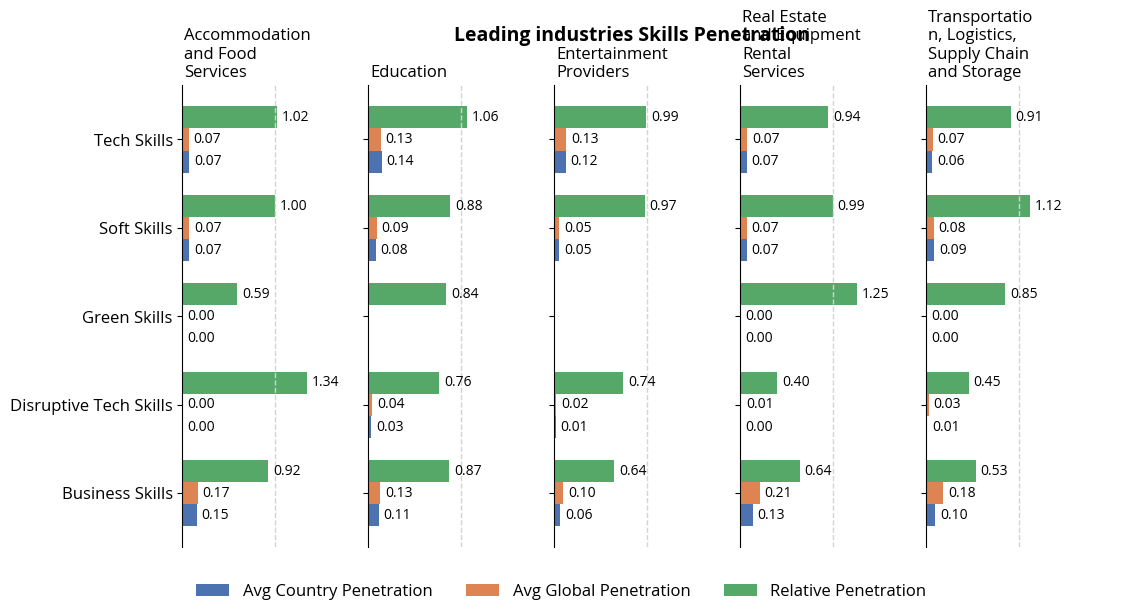

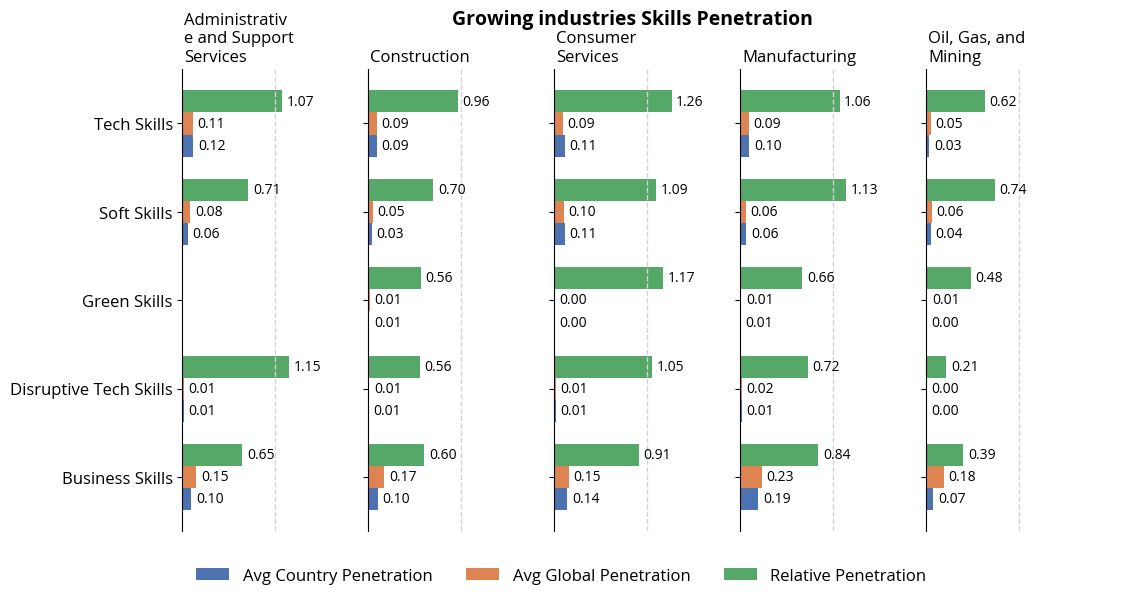

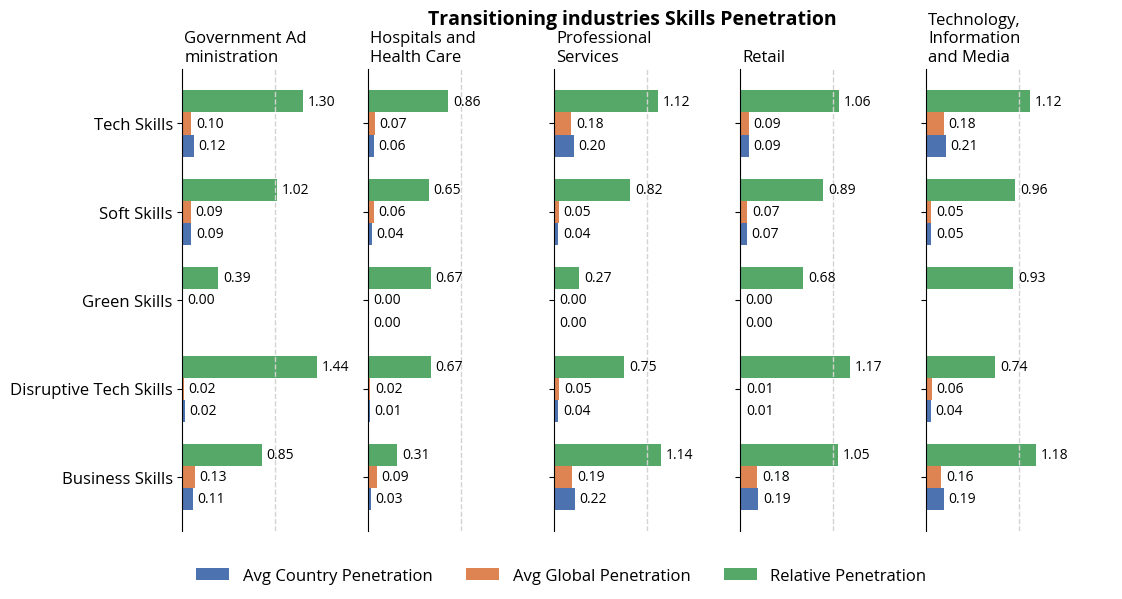

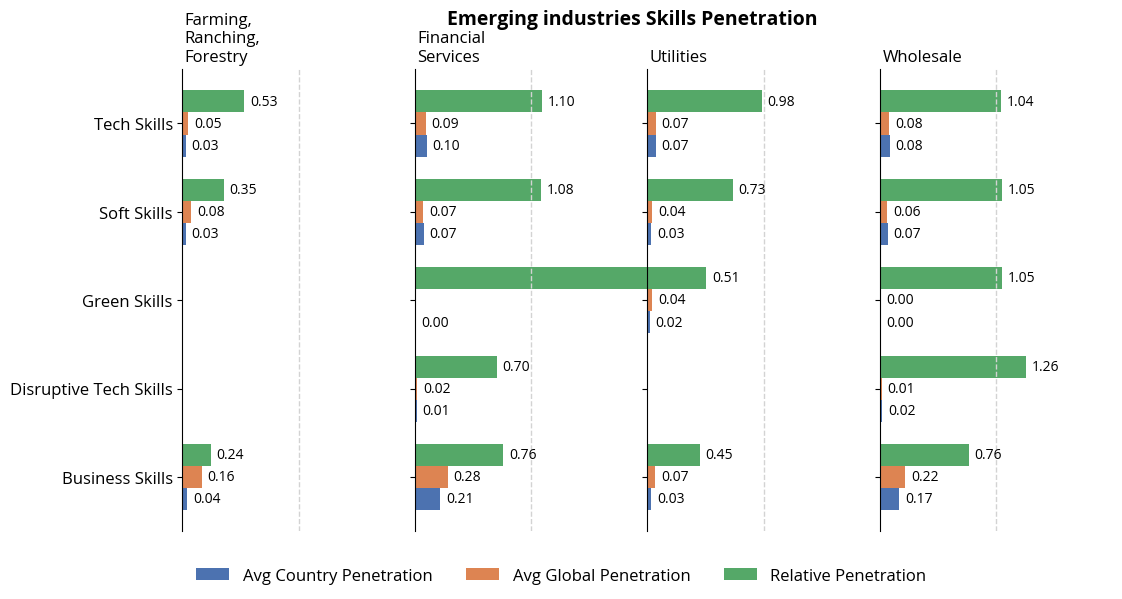

In [33]:
get_plot()

::::{tab-set}
:::{tab-item} Leading Industries
![leading_industries_skills_penetration.png](../../docs/images/bangladesh/leading_industries_skills_penetration.png)
:::
:::{tab-item} Growing Industries
![growing_industries_skills_penetration.png](../../docs/images/bangladesh/growing_industries_skills_penetration.png)
:::
:::{tab-item} Transitioning Industries
![transitioning_industries_skills_penetration.png](../../docs/images/bangladesh/transitioning_industries_skills_penetration.png)
:::
:::{tab-item} Emerging Industries
![emerging_industries_skills_penetration.png](../../docs/images/bangladesh/emerging_industries_skills_penetration.png)
:::
::::

**Insights**

- Tech skills are lagging compared to global average in Entertainment Providers, Real Estate, Oil, Gas and Mining, Hospitals and Health care and Farming and Ranching. Of these, 'Hospitals and Health Care' lacking tech skills could be a cause for concern given the increase in telehealth services globally. 
- Green Skills are lagging in Utilities, Manufacturing, Transportation, Logistics and Supply Chain, Construction and Retail where new jobs could be related to the renewable energy. 